In [696]:

import yfinance as yf  # import data from web (financial time series)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  ## interactive data visualization


In [697]:
##get stock data of the biggest companies


qqq = yf.Ticker("MSFT")
data = qqq.history(start="2016-01-01", end="2024-10-31")


data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-01-04 00:00:00-05:00,47.914032,48.337425,47.093707,48.337425,53778000,0.0,0.0
2016-01-05 00:00:00-05:00,48.452083,48.857834,48.108076,48.557930,34079700,0.0,0.0
2016-01-06 00:00:00-05:00,47.914013,47.984580,47.314205,47.675854,39518900,0.0,0.0
2016-01-07 00:00:00-05:00,46.485085,47.181921,45.929380,46.017586,56564900,0.0,0.0
2016-01-08 00:00:00-05:00,46.193991,46.996674,45.999938,46.158710,48754000,0.0,0.0


In [698]:
##data.Close.plot();
def calculate_rsi(data, window = 7):
    # Calculate price changes
    delta = data['Close'].diff()

    # Gains and losses
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    # Calculate RSI
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [699]:
def trading_strategy(data, initial_investment):
    # RSI calculation (assuming calculate_rsi is already defined elsewhere)
    rsi = calculate_rsi(data)
    signals = pd.DataFrame(index=data.index)
    signals['Signal'] = 0  
    
    sma100 = data['Close'].rolling(window=100).mean()
    sma20 = data['Close'].rolling(window=20).mean()
    
    # Initialize trading variables
    cash = initial_investment
    position = 0  # Number of shares held

    for i in range(len(data)):
        current_price = data['Close'].iloc[i]
        sma100_value = sma100.iloc[i]
        sma20_value = sma20.iloc[i]
        rsi_value = rsi.iloc[i]
        trade = ((sma20_value - sma100_value) / sma100_value) * 100
        
    
        if not np.isnan(sma100_value) and not np.isnan(rsi_value):
            # Buy Signal: Current price > SMA100 and RSI < 30
            if current_price > sma100_value and rsi_value < 30 or trade > 2 :
                signals['Signal'].iloc[i] = 1  # Buy signal
            # Sell Signal: Current price < SMA100 and RSI > 70
            elif current_price < sma100_value and rsi_value > 70 or trade < -5 :
                signals['Signal'].iloc[i] = -1  # Sell signal

        # Execute trades based on the signal
        if signals['Signal'].iloc[i] == 1:  # Buy signal
            shares_to_buy = cash // current_price  # Max shares to buy
            cash -= shares_to_buy * current_price  # Deduct cash spent
            position += shares_to_buy  # Add shares bought
        elif signals['Signal'].iloc[i] == -1:  # Sell signal
            cash += position * current_price  # Add cash from selling
            position = 0  # Reset position to zero
    
    # Final portfolio value
    final_value = cash + position * data['Close'].iloc[-1]
    return signals, final_value

In [700]:
def backtest(data, signals,initial_investment):
    # Combine the historical data with the trading signals
    df = pd.concat([data, signals], axis=1).dropna()

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Calculate cumulative returns
    df['Cumulative Return'] = (1 + df['Return']).cumprod()

    # Calculate portfolio value
    df['Portfolio Value'] = df['Cumulative Return'] * initial_investment

    # Calculate risk-free rate (assumed to be 0 in this example)
    risk_free_rate = 0

    # Calculate metrics
    num_trading_days = len(df)
    returns = df['Return']
    cumulative_returns = df['Cumulative Return']
    portfolio_value = df['Portfolio Value']
    annual_returns = (cumulative_returns[-1]) ** (252/num_trading_days) - 1
    volatility = returns.std() * np.sqrt(252)  # Annualized volatility
    sharpe_ratio = (annual_returns - risk_free_rate) / volatility
    cagr = (cumulative_returns[-1]) ** (252/num_trading_days) - 1
    # alpha, beta = np.polyfit(returns - risk_free_rate, market_returns - risk_free_rate, deg=1)
    variance = returns.var() * 252
    cvar = returns[returns <= np.percentile(returns, 5)].mean() * 252

    return df, sharpe_ratio, cagr, cumulative_returns,  variance, cvar

In [701]:
# Define initial investment amount

initial_investment = 10000

# Perform the trading strategy
signals, final_value = trading_strategy(data,initial_investment)

# Perform backtesting and calculate metrics
backtest_results, sharpe_ratio, cagr, cumulative_returns,  variance, cvar = backtest(data, signals,initial_investment)

C:\Users\GONCA\AppData\Local\Temp\ipykernel_7720\2996867158.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['Signal'].iloc[i] = -1  # Sell signal
C:\Users\GONCA\AppData\Local\Temp\ipykernel_7720\2996867158.py:25: FutureWarning: 

Number of holds 515
Number of sells 171
Number of buys 1536


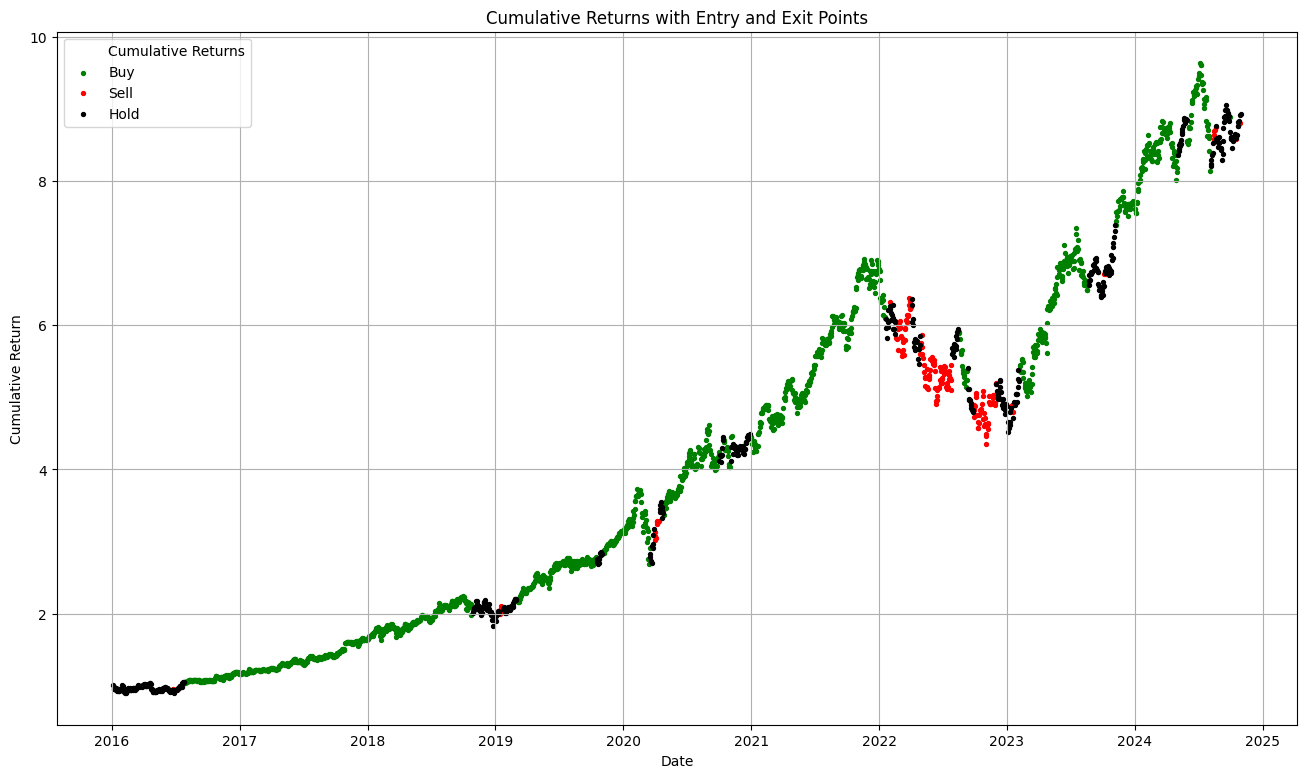

In [702]:
# Plot the cumulative returns with entry and exit points
print("Number of holds",len(signals[signals["Signal"]==0]))
print("Number of sells",len(signals[signals["Signal"]==-1]))
print("Number of buys",len(signals[signals["Signal"]==1]))

plt.figure(figsize=(16, 9))
plt.plot(backtest_results.index, cumulative_returns,linewidth=0 ,label='Cumulative Returns')
plt.scatter(backtest_results[backtest_results['Signal'] == 1].index, backtest_results[backtest_results['Signal'] == 1]['Cumulative Return'], color='green', s=8, label='Buy')
plt.scatter(backtest_results[backtest_results['Signal'] == -1].index, backtest_results[backtest_results['Signal'] == -1]['Cumulative Return'], color='red',  s=8, label='Sell')
plt.scatter(backtest_results[backtest_results['Signal'] == 0].index, backtest_results[backtest_results['Signal'] == 0]['Cumulative Return'], color='black',  s=8, label='Hold')
plt.title('Cumulative Returns with Entry and Exit Points')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()



In [703]:
# Print the calculated metrics
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"CAGR: {cagr:.2%}")
print(f"Cumulative Returns: {cumulative_returns[-1]:.2%}")
#print(f"Alpha: {alpha:.4f}")
#print(f"Beta: {beta:.4f}")
print(f"Variance: {variance:.6f}")
print(f"CVaR: {cvar:.6f}")
print(f"final value: {final_value:.6f}")

Sharpe Ratio: 1.04
CAGR: 28.19%
Cumulative Returns: 893.03%
Variance: 0.073306
CVaR: nan
final value: 56276.209557


C:\Users\GONCA\AppData\Local\Temp\ipykernel_7720\3391217156.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Cumulative Returns: {cumulative_returns[-1]:.2%}")


2º Parte com RL 

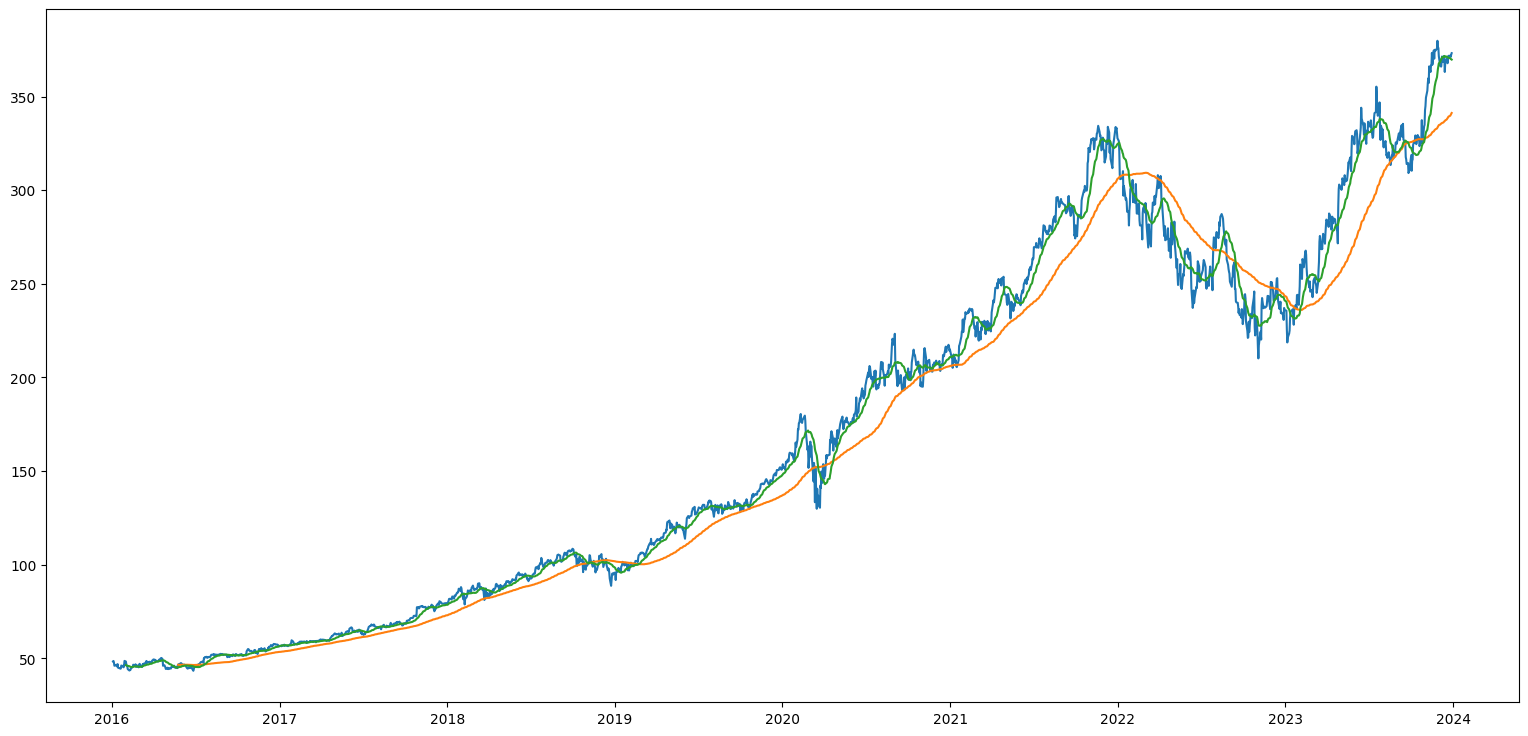

In [704]:

start_date = '2016-01-01'
end_date = '2023-12-31'

# Calculating the short-window simple moving average
short_rolling = data.rolling(window=20).mean()
short_rolling.head(20)
rsi= calculate_rsi(data)
long_rolling = data.rolling(window=100).mean()
long_rolling.tail()
fig, ax = plt.subplots(figsize=(19, 9))

# Plotting price and moving averages
ax.plot(data.loc[start_date:end_date].index, data.loc[start_date:end_date, 'Close'], label='QQQ Close Price')
ax.plot(long_rolling.loc[start_date:end_date].index, long_rolling.loc[start_date:end_date, 'Close'], label='100-days SMA')
ax.plot(short_rolling.loc[start_date:end_date].index, short_rolling.loc[start_date:end_date, 'Close'], label='20-days SMA')

# # Creating a secondary y-axis for RSI
# ax2 = ax.twinx()
# ax2.plot(rsi.loc[start_date:end_date].index, rsi.loc[start_date:end_date], label='RSI (7)', color='orange')
# ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
# ax2.axhline(30, color='green', linestyle='--', label='Oversold (30)')

# # Adding legends and labels
# ax.legend(loc='upper left')
# ax2.legend(loc='upper right')

# ax.set_ylabel('Price in $')
# ax2.set_ylabel('RSI')
# ax.set_title('Price and RSI Analysis')

plt.show()

In [705]:
class QLearningAgent:
    def __init__(self, num_states, num_actions, alpha, gamma):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.q_table = np.zeros((num_states, num_actions))

    def update_q_table(self, state, action, reward, next_state):
        # Q-learning update rule
        max_q_value = np.max(self.q_table[next_state])
        self.q_table[state, action] += self.alpha * (reward + self.gamma * max_q_value - self.q_table[state, action])

    def choose_action(self, state, epsilon, current_price, sma100_value, sma20_value, rsi_value, strategyProb):
        # Calculate the percentage difference between SMA20 and SMA100
        trade = ((sma20_value - sma100_value) / sma100_value) * 100
    

        # Exploration: Random action with probability epsilon
        if np.random.uniform() < epsilon:
            return np.random.choice(self.num_actions)

        if np.random.uniform() < strategyProb:
            # Buy Signal: Current price > SMA100 and RSI < 30, wallet has cash
            if current_price > sma100_value and rsi_value < 30  or trade > 2 :
                return 2  # Buy
            # Sell Signal: Current price < SMA100 and RSI > 70, holding shares
            elif current_price < sma100_value and rsi_value > 70  or trade < -5 :
                return 0  # Sell
            else:
                return 1 #Hold

        # Exploitation: Use the Q-table to select the best action
        return np.argmax(self.q_table[state])

In [706]:
# Define the trading strategy with Q-learning and human feedback
def trading_strategy(data, q_agent, initial_investment, epsilon,strategyProb):
    #Number of states (0: out of the market, 1: in the market)
    #Number of actions (0: sell, 1: hold ,2: buy)

    total_reward = 0  # Track total reward
    portfolio_value = [0]  # Track portfolio value
    wallet = initial_investment # wallet
    asset = [initial_investment] #patrimonio
    trades = []  # Track executed trades
    shares = 0 
    data['SMA100'] = data['Close'].rolling(window=100).mean()
    data['SMA20'] = data['Close'].rolling(window=20).mean()
    data['RSI'] = calculate_rsi(data)

    one_third_point = len(data) / 3
    two_third_point = 2 * len(data) / 3


    # Iterate over each trading day
    for i in range(len(data) - 1):

        # Choose the action using epsilon-greedy policy
        if i == one_third_point:
            strategyProb /= 4
            epsilon /= 4
        if i == two_third_point:
            strategyProb /= 2
            epsilon /= 2

        if( i == 0 ): 
            action = 1
            state = 0
        else:   
            action = q_agent.choose_action(state, epsilon, data['Close'][i], data['SMA100'][i], data['SMA20'][i],data['RSI'][i],strategyProb) 
        # Execute the action
        
        if action == 2 and state == 0:
            state = 1  # Enter the market
            shares = wallet / data['Close'][i]  # Buy as many shares as possible
            trades.append(('BUY', data.index[i], data['Close'][i], shares))
            wallet = 0 
            
        elif action == 0 and state == 1:
            state = 0  # Exit the market
            wallet = shares * data['Close'][i] #sell everthing 
            trades.append(('SELL', data.index[i], data['Close'][i], shares))
            shares =  0

        elif action == 1:  # Hold action
            # Do nothing, portfolio remains unchanged
            pass
        
        if( action == 2 or action == 0):
            reward = ((asset[-1] - asset[-2]) / asset[-2] )  if i > 0 else 0
        else:   
            reward = ( data["Close"][i] - data["Close"][i-1] / data["Close"][i-1]) 


        # Calculate the reward based on the portfolio value change
        total_reward += reward

        # Update the Q-table
        next_state = 0 if state == 0 else 1  # Next state

        q_agent.update_q_table(state, action, reward, next_state)

        # Update the portfolio value
        portfolio_value.append(shares * data['Close'][i])
        asset.append(portfolio_value[i+1] + wallet)
      
        

    return total_reward, asset, trades

In [ ]:
# Set the initial investment
initial_investment = 10000
epsilon=0.1
strategyProb=0.55
mean = 0
for i in range(1000):
    # Create the Q-learning agent
    q_agent = QLearningAgent(num_states=2, num_actions=3, alpha=0.9, gamma=0.1)

    # Apply the trading strategy
    total_reward, asset_value, trades = trading_strategy(data, q_agent, initial_investment,epsilon,strategyProb)
    mean += asset_value[-1]

C:\Users\GONCA\AppData\Local\Temp\ipykernel_7720\2888995868.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reward = ( data["Close"][i] - data["Close"][i-1] / data["Close"][i-1])
C:\Users\GONCA\AppData\Local\Temp\ipykernel_7720\2888995868.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value.append(shares * data['Close'][i])
C:\Users\GONCA\AppData\Local\Temp\ipykernel_7720\2888995868.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

In [ ]:
mean = mean/1000
mean

np.float64(55683.47302532282)

1. dar track a quantidade de ações 
2. não vender todo, ser parcial nada 
3. atualizar sempre o portofolio com os valores correspondentes as ações vendidas ou compradas
4. nova ação, hold (não fazer nada)

In [ ]:


# Define ranges for epsilon, strategy probability, alpha, and gamma
epsilons = np.linspace(0.1, 1.0, 5)  # Epsilon values (from 0.1 to 1.0 in 5 steps)
strategyProbs = np.linspace(0.1, 1.0, 5)  # Strategy probability values (from 0.1 to 1.0 in 5 steps)
alphas = np.linspace(0.1, 0.9, 5)  # Alpha values (learning rate)
gammas = np.linspace(0.1, 0.9, 5)  # Gamma values (discount factor)

# Create a list to store results
results = []

# Perform a grid search over epsilon, strategyProb, alpha, and gamma
for epsilon in epsilons:
    for strategyProb in strategyProbs:
        for alpha in alphas:
            for gamma in gammas:
                asset_values = []

                # Perform 10 attempts for each (epsilon, strategyProb, alpha, gamma) combination
                for attempt in range(10):
                    # Set initial investment and create Q-learning agent with the current parameters
                    initial_investment = 10000
                    q_agent = QLearningAgent(num_states=2, num_actions=3, alpha=alpha, gamma=gamma)

                    # Apply the trading strategy with the current parameters
                    total_reward, asset_value, trades = trading_strategy(data, q_agent, initial_investment,epsilon,strategyProb)

                    # Store the final asset value of this attempt
                    asset_values.append(asset_value[-1])

                # Calculate the mean final asset value for this combination of parameters
                mean_asset_value = np.mean(asset_values)

                # Store the result for this combination
                results.append({
                    'epsilon': epsilon,
                    'strategyProb': strategyProb,
                    'alpha': alpha,
                    'gamma': gamma,
                    'mean_final_asset_value': mean_asset_value
                })

# After running the grid search, you can analyze the results
# Example: find the best configuration (maximum mean final asset value)
best_result = max(results, key=lambda x: x['mean_final_asset_value'])






In [ ]:
print(f"Best Epsilon: {best_result['epsilon']}, Best Strategy Prob: {best_result['strategyProb']}, "
      f"Best Alpha: {best_result['alpha']}, Best Gamma: {best_result['gamma']}, "
      f"Mean Final Asset Value: {best_result['mean_final_asset_value']}")

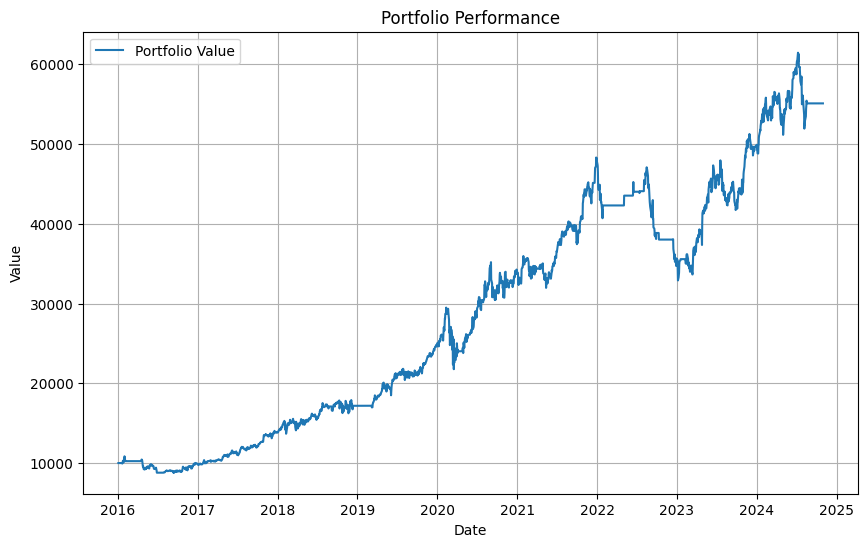

In [ ]:
# Calculate metrics
returns = np.diff(asset_value) / asset_value[:-1]
sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)
cagr = (asset_value[-1] / asset_value[0]) ** (252 / len(data)) - 1
cumulative_returns = (asset_value[-1] - asset_value[0]) / asset_value[0]
variance = np.var(returns)
cvar = np.mean(returns[returns < np.percentile(returns, 5)])
alpha, beta = np.polyfit(data['Close'].pct_change().dropna(), returns, deg=1)

# Plot portfolio performance
plt.figure(figsize=(10, 6))
plt.plot(data.index, asset_value, label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Portfolio Performance')
plt.legend()
plt.grid(True)
plt.show()